In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import networkx as nx


from scipy import signal
from scipy.fft import fft, ifft
import scipy.stats as ss

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

# Loading data

In [2]:
df = pd.read_csv("COVID_Data_Hub.csv")
df['date'] =pd.to_datetime(df.date)

In [3]:
df

,date,confirmed,deaths,tests,positives,recovered,hosp,icu,vent,population,administrative_area_level,administrative_area_level_1,administrative_area_level_2,administrative_area_level_3,id,state_abbrev
0,2020-01-25,4,0,0,0,0,0.0,0,0,25459470,1,Australia,NaN,NaN,99999999,NaN
1,2020-01-26,4,0,0,0,0,0.0,0,0,25459470,1,Australia,NaN,NaN,99999999,NaN
2,2020-01-27,5,0,0,0,0,0.0,0,0,25459470,1,Australia,NaN,NaN,99999999,NaN
3,2020-01-28,5,0,0,0,0,0.0,0,0,25459470,1,Australia,NaN,NaN,99999999,NaN
4,2020-01-29,9,0,0,0,0,0.0,0,0,25459470,1,Australia,NaN,NaN,99999999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,2021-02-06,1311,6,1803657,1311,1294,5.0,0,0,5115451,2,Australia,Queensland,NaN,36068882,QLD
3407,2021-02-06,602,4,984710,602,596,0.0,0,0,1756494,2,Australia,South Australia,NaN,165128d0,SA
3408,2021-02-06,234,13,161722,234,221,0.0,0,0,535500,2,Australia,Tasmania,NaN,86525f8e,TAS
3409,2021-02-06,20456,820,4543879,20456,19614,0.0,0,0,6629870,2,Australia,Victoria,NaN,6c5dccdb,VIC


In [4]:
df.isna().sum()

date                              0
confirmed                         0
deaths                            0
tests                             0
positives                         0
recovered                         0
hosp                              0
icu                               0
vent                              0
population                        0
administrative_area_level         0
administrative_area_level_1       0
administrative_area_level_2     379
administrative_area_level_3    3411
id                                0
state_abbrev                    379
dtype: int64

In [5]:
df = df.drop(columns="administrative_area_level_3")
df['administrative_area_level_2'] = df['administrative_area_level_2'].fillna("National")

df = df.rename({'administrative_area_level_2':'region'}, axis='columns')

In [6]:
df['confirmed_per_capita'] = df['confirmed']/df['population']*1e6

## Removing data with less than 5 cases per 1M

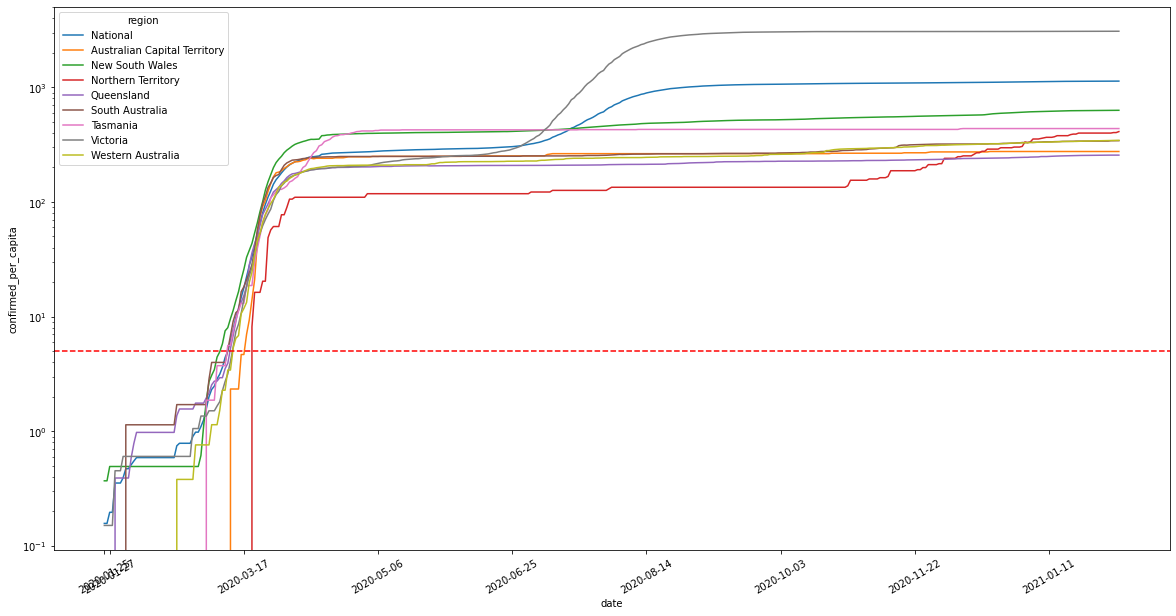

In [7]:
plt.figure(figsize=(20,10))
grid = sns.lineplot(data=df, x='date', y='confirmed_per_capita', hue="region", legend=True)
grid.set(yscale="log")
grid.set(xticks=df.date[0::400])
_ = plt.xticks(rotation=30) 
plt.axhline(y=5, color='r', linestyle='--')

In [8]:
df2 = df.loc[df['confirmed_per_capita'] >= 5]

## Setting day with 5 cases per 1M as day 0

In [9]:
start_date = df2.groupby('region')['date'].min()
start_date

region
Australian Capital Territory   2020-03-18
National                       2020-03-12
New South Wales                2020-03-09
Northern Territory             2020-03-20
Queensland                     2020-03-12
South Australia                2020-03-11
Tasmania                       2020-03-11
Victoria                       2020-03-13
Western Australia              2020-03-13
Name: date, dtype: datetime64[ns]

In [10]:
dev = []
for s in start_date.index:
    tmp = df2.loc[df2['region']==s]['date'] - start_date[s]
    dev.append(tmp)
    
development = pd.concat(dev)
development = development.sort_index()
development = pd.DataFrame(development)
development = development.rename({'date':'development'}, axis='columns')

development['development'] /= np.timedelta64(1, 'D')

In [11]:
df2 = pd.merge(df2, development,left_index=True, right_index=True)

### Time series plot with x-axis as Development

[None]

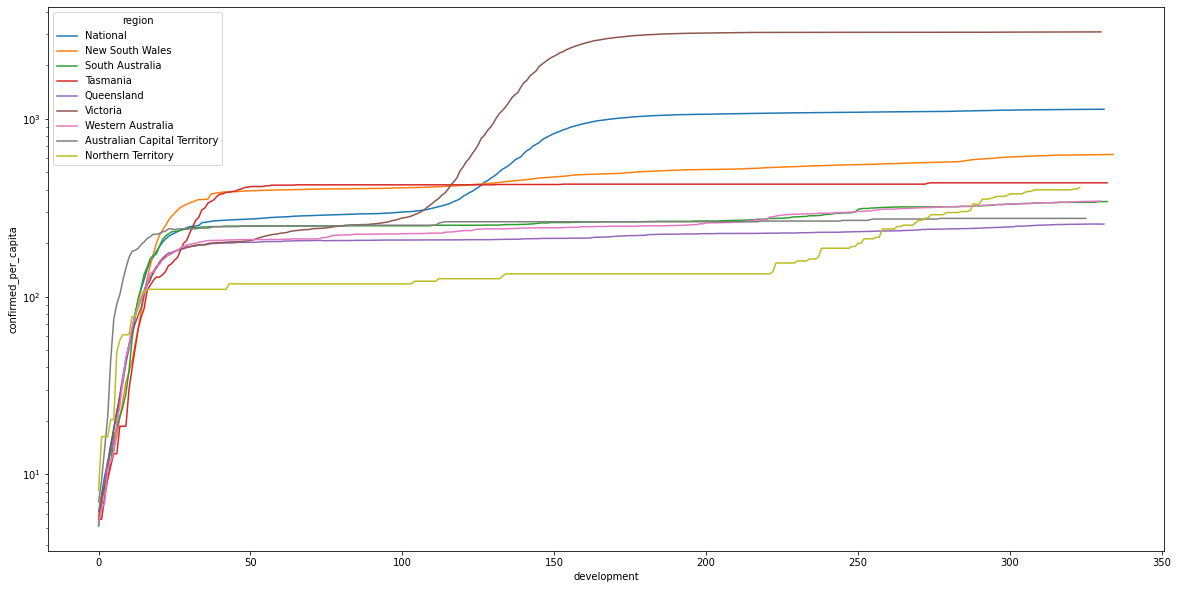

In [12]:
plt.figure(figsize=(20,10))
grid = sns.lineplot(data=df2, x='development', y='confirmed_per_capita', hue="region", legend=True)
grid.set(yscale="log")
#grid.set(xticks=df2.date[0::400])
#plt.axhline(y=5, color='r', linestyle='--')

## Finding rate of change in confirmed cases

In [13]:
tmp = df2[['date','region','confirmed']]

In [14]:

from datetime import timedelta
delta = []
for r in tmp.region.unique():
    index = tmp.loc[tmp['region']==r].iloc[:-1].index
    confirmed_region_t0 = tmp.loc[tmp['region']==r].iloc[:-1].reset_index()
    confirmed_region_t1 = tmp.loc[tmp['region']==r].iloc[1:].reset_index()
    
    inc = (confirmed_region_t1['confirmed']/confirmed_region_t0['confirmed']) - 1
    
    inc.index = index
    delta.append(inc)
    
delta = pd.concat(delta)
delta = delta.sort_index()
delta = pd.DataFrame(delta)
delta = delta.rename({'confirmed':'% increase'}, axis='columns')

In [15]:
df2 = pd.merge(df2, delta,left_index=True, right_index=True)


In [16]:
df2["log(% increase)"] = np.log(np.abs(df2["% increase"])+1e-10)
df_reg = df2.loc[df2['% increase']!=0.0]

### Sample plot for "Queensland"

<AxesSubplot:xlabel='development', ylabel='log(% increase)'>

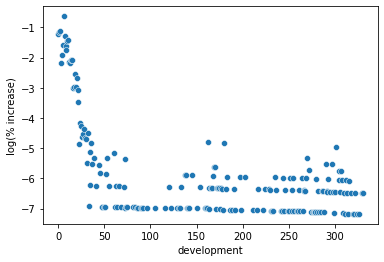

In [17]:
sns.scatterplot(data=df_reg.loc[df_reg['region'] == 'Queensland'], x='development',y='log(% increase)')

### Scatter plot of the rate of increase in cases

<AxesSubplot:xlabel='development', ylabel='% increase'>

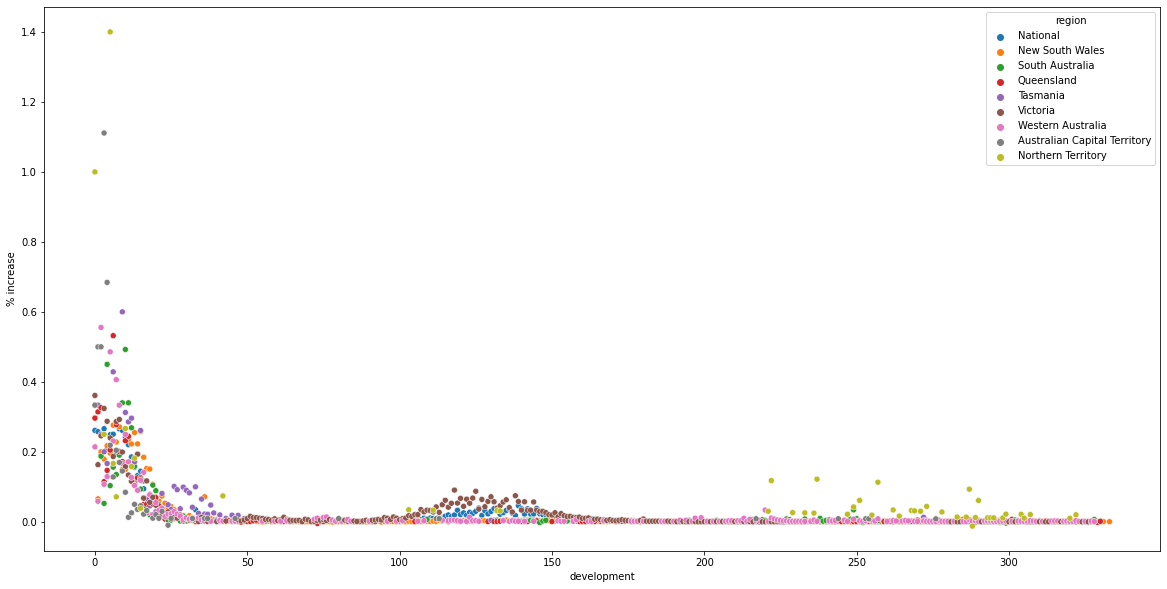

In [18]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_reg, x='development',y='% increase', hue='region')

<AxesSubplot:xlabel='development', ylabel='log(% increase)'>

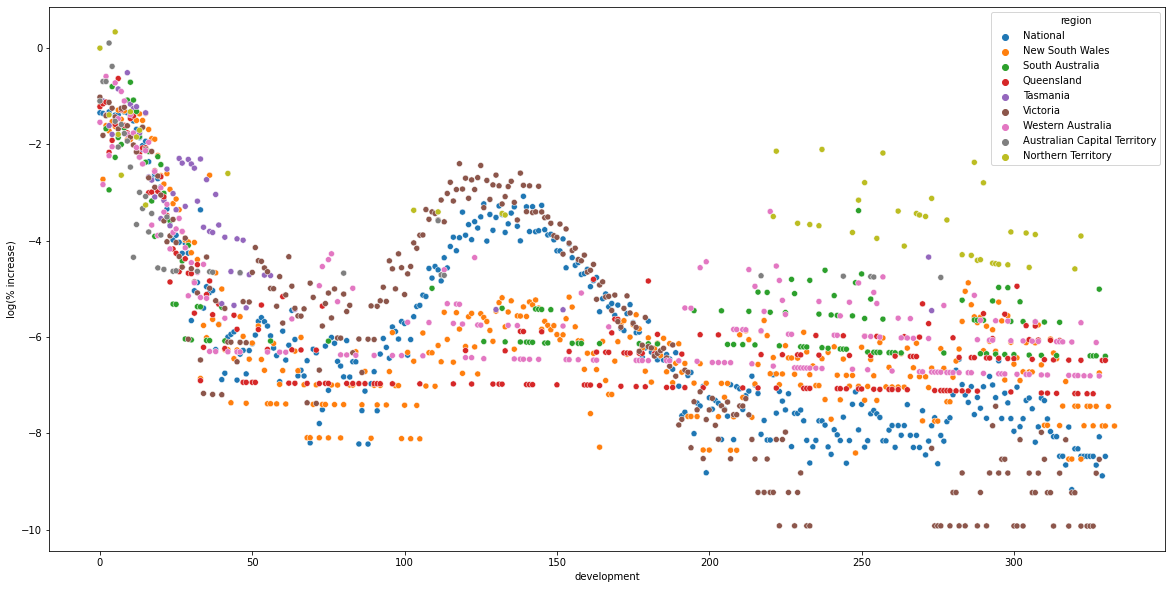

In [19]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_reg, x='development',y='log(% increase)', hue='region')

## Smoothing data

In [20]:
def lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y.astype(np.float32)

In [21]:
fs = 1
cutoff = 0.017
nyq = 0.5 * fs  
order = 3

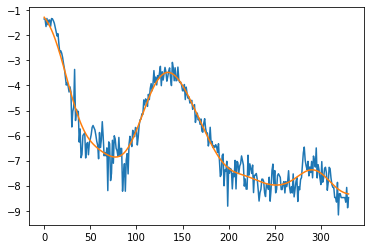

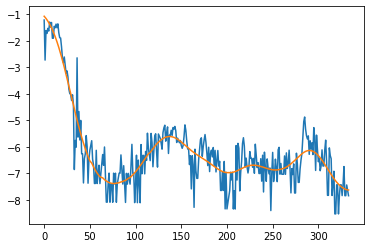

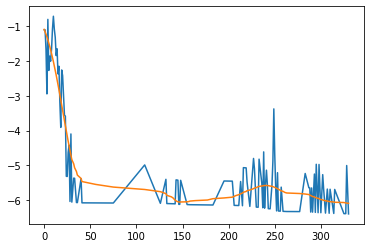

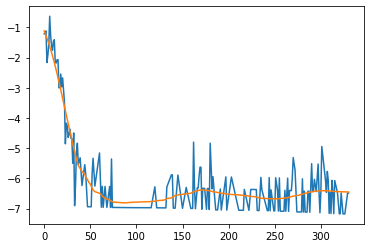

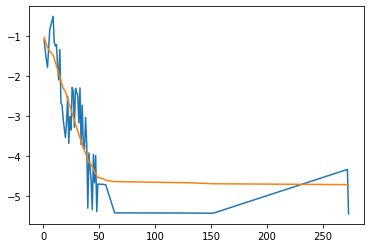

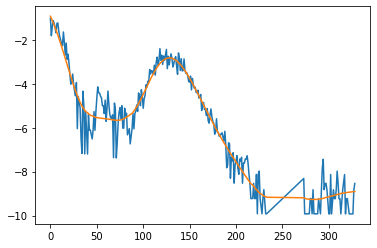

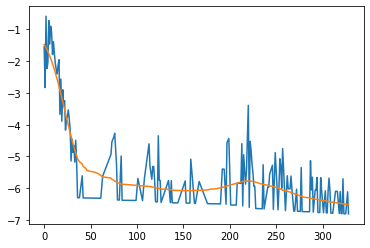

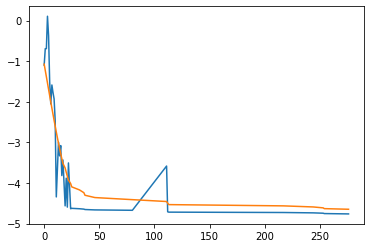

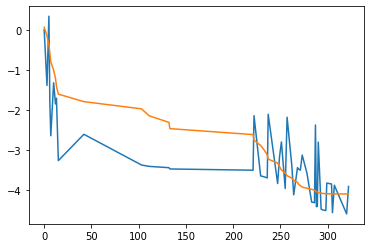

In [22]:
log_inc_smooth = []
for r in df_reg['region'].unique():
    x = df_reg.loc[df_reg['region']==r]['development'].values.reshape(-1, 1) 
    y = df_reg.loc[df_reg['region']==r]['log(% increase)'].values
    Y = lowpass_filter(y,cutoff,fs,order)
    plt.plot(x,y)
    plt.plot(x,Y)
    plt.show()
    
    index = df_reg.loc[df_reg['region']==r].index
    log_inc_smooth.append(pd.Series(data=Y, index=index))

log_inc_smooth = pd.concat(log_inc_smooth)
log_inc_smooth = log_inc_smooth.sort_index()
log_inc_smooth = pd.DataFrame(log_inc_smooth)
log_inc_smooth = log_inc_smooth.rename({0:'log_inc_smooth'}, axis='columns')   


In [23]:
df_reg = pd.merge(df_reg, log_inc_smooth, left_index=True, right_index=True)

<AxesSubplot:xlabel='development', ylabel='log_inc_smooth'>

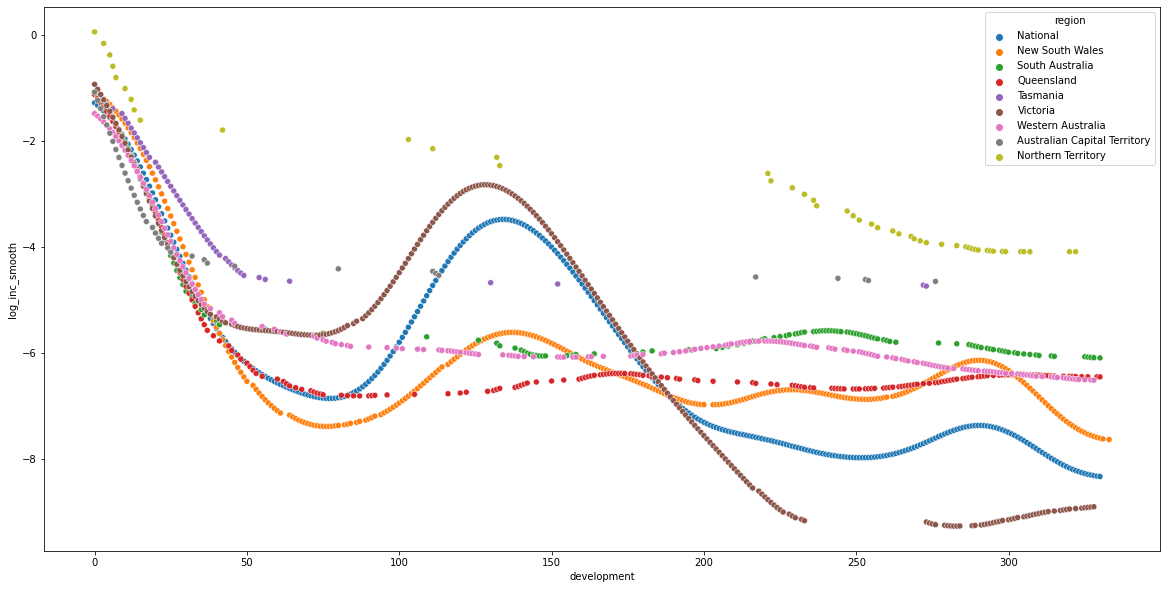

In [24]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_reg, x='development',y='log_inc_smooth', hue='region')

# Model

In [25]:
tmp = df_reg.loc[df_reg['region']=="Queensland"].reset_index()['log_inc_smooth']
tmp.isna().sum()

0

## Check autocorrelation of  log_inc_smooth for "Queensland"

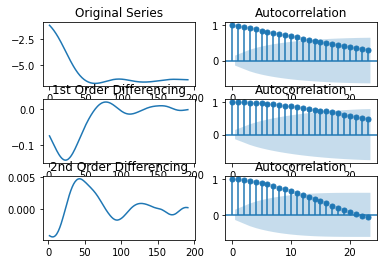

In [26]:
# find the number of differencing required (d)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(tmp); axes[0, 0].set_title('Original Series')
plot_acf(tmp, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(tmp.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(tmp.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(tmp.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tmp.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

##  Check partial autocorrelation of  log_inc_smooth for "Queensland" 

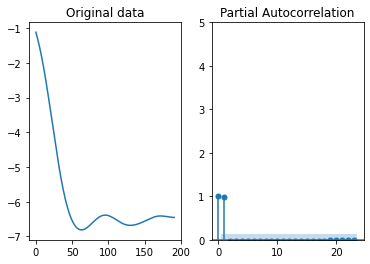

In [27]:
# to find the order of the AR term (p)

# PACF plot of 1st differenced series

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(tmp); axes[0].set_title('Original data')
axes[1].set(ylim=(0,5))
plot_pacf(tmp.dropna(), ax=axes[1])

plt.show()

## Fit ARIMA model

In [28]:
# p is the order of the AR term
# q is the order of the MA term
# d is the number of differencing required to make the time series stationary
p = 2
q = 1
d = 0

train = tmp[:180]
test = tmp[180:]

In [35]:

import pmdarima as pm
model_fit = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1159.079, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=661.583, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.589 seconds


In [37]:


# 1,1,2 ARIMA Model
model = ARIMA(train, order=(2,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

e:\program files\python3\venv\tf-gpu\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:      D2.log_inc_smooth   No. Observations:                  178
Model:                 ARIMA(2, 2, 1)   Log Likelihood                1914.699
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 10 Feb 2021   AIC                          -3819.399
Time:                        13:23:17   BIC                          -3803.490
Sample:                             2   HQIC                         -3812.947
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0006      0.000      4.433      0.000       0.000       0.001
ar.L1.D2.log_inc_smooth     1.9872      0.004    443.030      0.000       1.978       1.996


e:\program files\python3\venv\tf-gpu\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


# Plot residual errors

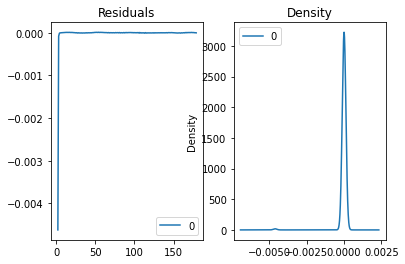

In [38]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

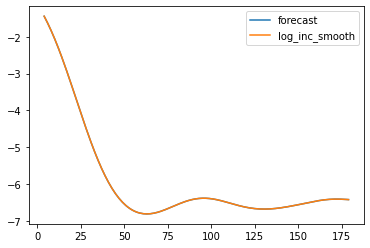

In [39]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

# Forecast

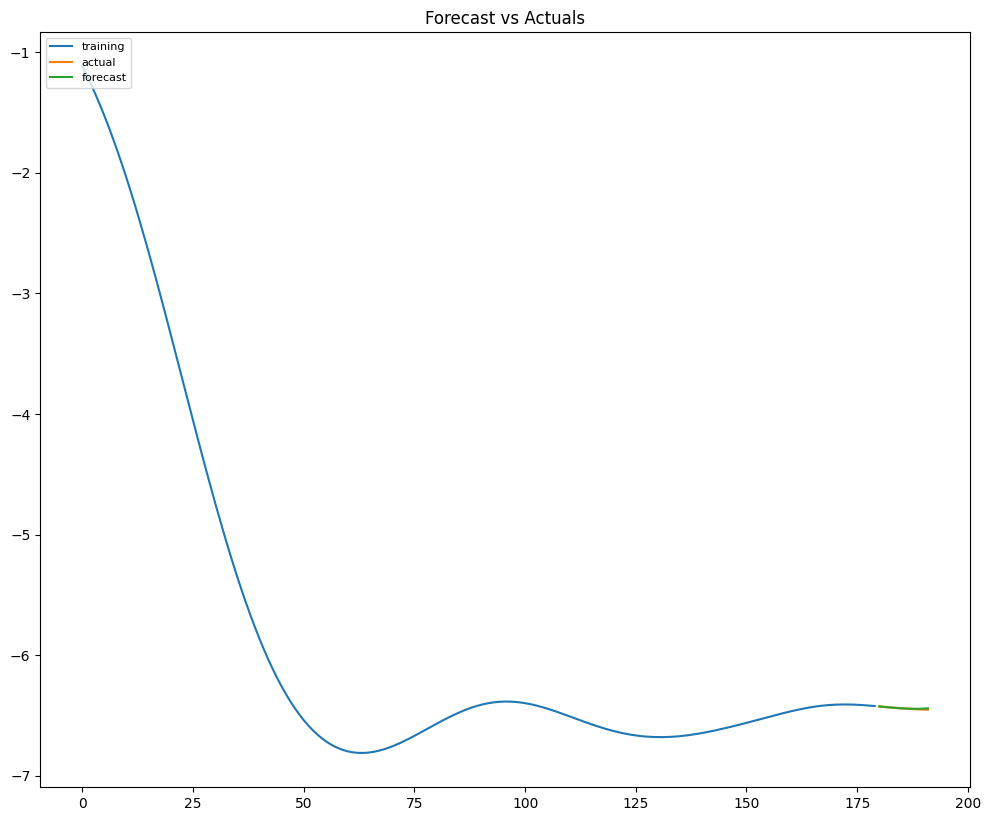

In [40]:
# Forecast
fc, se, conf = model_fit.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,10), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Recreating original data from predictions

In [46]:
log_per_inc = fc
per_inc = np.exp(log_per_inc)
inc_fac = per_inc + 1
inc_fac

array([1.00162084, 1.00161548, 1.00161021, 1.00160522, 1.00160065,
       1.00159669, 1.00159348, 1.00159121, 1.00159003, 1.0015901 ,
       1.00159159, 1.00159466])